# Part 1 - RGB Images

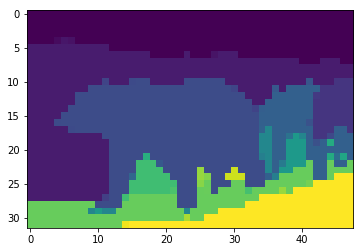

(321, 481, 3)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import rescale
import numpy as np
import scipy.io as sio
import os

# Path of images
path = 'C:/Users/DarkB/Downloads/ML Python Scripts/Project 1/ImsAndSegs'

# Load image data
img_load = sio.loadmat('C:/Users/DarkB/Downloads/ML Python Scripts/Project 1/ImsAndSegs/ImsAndTruths100075.mat')
img = img_load['Im']
seg_im = img_load['Seg1']

# Plot image
plt.imshow(rescale(seg_im,0.1,mode='reflect'))
plt.show()
img.shape

## K-Means Algorithm Implementation

KMeans clustering time to do: 0.04s


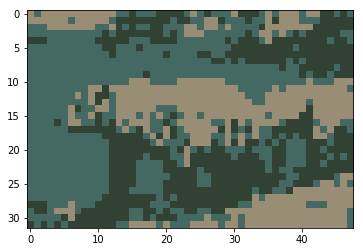

In [3]:
import time
import numpy as np
from sklearn.cluster import KMeans


#Downsample image
img_r = rescale(img,0.1,mode='reflect')
img_flat = img_r.reshape(img_r.shape[0] * img_r.shape[1], 3)
n_clusters = 3 

t0 = time.time()
# Initializing KMeans
kmeans = KMeans(n_clusters = n_clusters)

# Fitting with inputs
kmeans = kmeans.fit(img_flat)
clusters = kmeans.cluster_centers_[kmeans.predict(img_flat)]
t1 = time.time()

# Reshape flattened image
img_clustered = clusters.reshape(img_r.shape)

# Plot image
plt.imshow(img_clustered)
title = 'KMeans clustering time to do: %.2fs' % (t1 - t0)
print(title)
plt.show()

 Step 1 - Binary Clusters Images (ONE CLUSTER)- Time to do: 0.39s


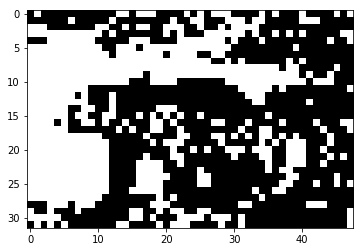

Step 2 - Label Connected Components - Time to do: 0.00s


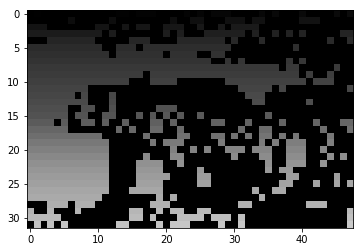

Step 3 - Remove Small Connected Components - Time to do: 0.00s


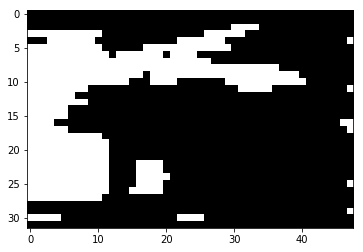

Step 4 - Smoothing Image - Time to do: 0.00s


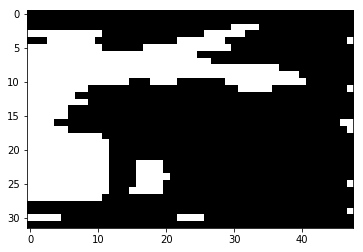

In [4]:
from skimage import measure
from skimage import morphology
from scipy.ndimage.filters import gaussian_filter

# Step 1 - Binary Clusters Images

# Separate the clusters into binary images --> This step need to be transformed into a function 
# that takes the number of clusters selected and separete into a binary image for each cluster
# Currently only works for ONE of the clusters

t0 = time.time()

first_cluster = np.copy(clusters)
for colors in range(first_cluster.shape[0]):
    if np.array_equal(first_cluster[colors],[np.unique(img_clustered)[3], np.unique(img_clustered)[5], np.unique(img_clustered)[4]]):
#         first_color[colors] = [np.unique(r_recolored)[3], np.unique(r_recolored)[5], np.unique(r_recolored)[4]]
          first_cluster[colors] = [1,1,1]
    else:
        first_cluster[colors] = [0,0,0]
        
cluster_1 = (first_cluster.reshape(img_r.shape))

t1 = time.time()

# Step 2 - Label Connected Components

# The connected components are labeled based on connected regions assiging the same integer value, based on 4 neighbors (default)
# This needs to be set within the funtion that evaluates each binary cluster image to label its connected components
# Reference: http://scikit-image.org/docs/dev/api/skimage.measure.html

t2 = time.time()

img_flat = first_cluster
all_labels = measure.label(img_flat)
img_labeled_by_components = all_labels.reshape(img_clustered.shape)

t3 = time.time()

# Step 3 - Remove Small Connected Components

# Remove connected components smaller than the specified size, in this case i picked 10 but this might change
# and reconver the image from labels into binary. Agains need to be placed into the generalized function
# Reference: http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects

t4 = time.time()

clean_cluster = morphology.remove_small_objects(img_labeled_by_components, 10)
clean_cluster[clean_cluster > 1] = 1
clean_cluster = clean_cluster.astype(float)

t5 = time.time()

# Step 4 - Smoothing Image

# The cleaned image is passed through a gaussing filter to smooth the output, it is not entirelly clear to me how it works
# so we might or mightn ot use this step

t6 = time.time()

img_flat_clean = clean_cluster.reshape(clean_cluster.shape[0] * clean_cluster.shape[1], 3)

s = 0.5 # sigma
w = 5 # window size
t = (((w - 1)/2)-0.5)/s #truncate


blurred = gaussian_filter(img_flat_clean, sigma=s, order=0, truncate=t)
blobs = blurred > 0.5 * blurred.mean()

img_cluster_filt = blobs.reshape(img_clustered.shape)

t7 = time.time()

# Step 5 - Vizualization

# This just plot the images

plt.figure(1)
plt.imshow(cluster_1)
title = ' Step 1 - Binary Clusters Images (ONE CLUSTER)- Time to do: %.2fs' % (t1 - t0)
print(title)
plt.show()
plt.figure(2)
plt.imshow(img_labeled_by_components)
title = 'Step 2 - Label Connected Components - Time to do: %.2fs' % (t3 - t2)
print(title)
plt.show()
plt.figure(3)
plt.imshow(clean_cluster)
title = 'Step 3 - Remove Small Connected Components - Time to do: %.2fs' % (t5 - t4)
print(title)
plt.show()
plt.figure(4)
plt.imshow(img_cluster_filt.astype(float))
title = 'Step 4 - Smoothing Image - Time to do: %.2fs' % (t7 - t6)
print(title)
plt.show()